# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Дерево решений


**Общая информация**

**Срок сдачи:** до 1 ноября 2018, 06:00 
**Штраф за опоздание:** -2 балла после 06:00 1 ноября, -4 балла после 06:00 8 ноября, -6 баллов после 06:00 15 ноября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw2.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (4 балла)
Разберитесь в коде MyDecisionTreeClassifier, который уже частично реализован. В комментариях, где написано "Что делает этот блок кода?", ответьте на этот вопрос. Допишите код там, где написано "Ваш код". Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn. Точность проверяется на wine и Speed Dating Data.

###### Задание 2 (2 балла)
Добиться скорости работы fit такой, чтобы она была медленнее sklearn не более чем в 10 раз. Скорость проверяем на  wine и Speed Dating Data. Для ускорения используем только numpy.

###### Задание 3 (2 балла)
Добавьте функционал, который определяет значения feature importance. Выведите 10 главных фичей под пунктом Задание 3 (уже написано ниже) для MyDecisionTreeClassifier и DecisionTreeClassifier так, чтобы сразу были видны выводы и по MyDecisionTreeClassifier, и по DecisionTreeClassifier. Используем данные Speed Dating Data.

###### Задание 4 (2 балла)
С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса (Выберете 2-3 параметра). Используем данные Speed Dating Data. Задание реализуйте под пунктом Задание 4 (уже написано ниже)


**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
%load_ext pycodestyle_magic

In [634]:
%%pycodestyle


class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2,
                 max_depth=None, sufficient_share=1.0,
                 criterion='gini', max_features=None):
        # Дерево задано с помощью словаря
        self.tree = dict()
        # Минимальное количество элементов в узле
        # Если меньше этого количества, то делим, иначе это вершина
        self.min_samples_split = min_samples_split
        # Максимальная глубина дерева
        self.max_depth = max_depth
        # Минимальная доля определенного класса,
        # которая определяет принадлежность к классу,
        # создание нового листа
        self.sufficient_share = sufficient_share
        # Начальное количество классов
        self.num_class = -1
        # Важность признаков
        self.feature_importances_ = None

        # Меры неопределенности. Прирост информации
        if criterion == 'gini':
            self.G_function = self.__gini
            self.importance_G_function = self.__importance_gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
            self.importance_G_function = self.__importance_entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
            self.importance_G_function = self.__importance_misclass
        else:
            print('invalid criterion name')
            raise

        # Количество признаков,
        # которые нужно учитывать при поиске лучшего разделения:
        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features is None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise

    def __importance_gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        return y.size * (1 - np.sum((counts / y.size) ** 2))

    def __importance_entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        return - y.size * np.sum((counts / y.size) * np.log2(counts / y.size))

    def __importance_misclass(self, y):
        _, counts = np.unique(y, return_counts=True)
        return y.size * (1 - np.max(counts / y.size))

    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        return ((1 - (((l_c / l_s) ** 2).sum(axis=1))).
                reshape(-1, 1) * l_s +
                (1 - (((r_c / r_s) ** 2).sum(axis=1))).
                reshape(-1, 1) * r_s) / (l_s + r_s)

    def __entropy(self, l_c, l_s, r_c, r_s):
        return -(((l_c/l_s) * np.log2(l_c/l_s)).sum(axis=1).
                 reshape(-1, 1) * l_s +
                 ((r_c/r_s) * np.log2(r_c/r_s)).sum(axis=1).
                 reshape(-1, 1) * r_s) / (l_s + r_s)

    def __misclass(self, l_c, l_s, r_c, r_s):
        return ((1 - (l_c/l_s).max(axis=1)).reshape(-1, 1) * l_s +
                (1 - (r_c/r_s).max(axis=1)).reshape(-1, 1) * r_s) / (l_s + r_s)

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.sqrt(n_feature))]

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.log2(n_feature))]

    def __get_feature_ids_N(self, n_feature):
        return np.arange(n_feature)

    def __sort_samples(self, x, y):
        # Сортировка x и y в порядке возрастания x
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        # Разделение выборки на 2 части:
        # левая: если значение определенного признака
        # больше некоторого порога
        # правая: все остальное
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        # Что делает этот блок кода?
        '''
        Поиск порога критерия для успешного разделения в узле на две части
        и поиск значения наименьшей неопределенности
        '''
        # Сортировка x и y в порядке возрастания признака x
        sorted_x, sorted_y = self.__sort_samples(x, y)

        # Подсчитываем количество классов
        class_number = self.num_class
        cut_size = np.int(self.min_samples_split / 2 - 1)

        # Что делает этот блок кода?
        # Выделение тех значений y, индексы, которых лежат
        # посередине, т.е. первые cut_size элементов и пропускаем
        # и последние cut_size элементов пропускаем

        if cut_size == 0:
            splitted_sorted_y = sorted_y
        else:
            splitted_sorted_y = sorted_y[cut_size:-cut_size]

        # Поиск тех позиций целевой функции, в которых,
        # следующий класс не равен предыдущему(берется правая позиция),
        # т.е ищем те места, где классы меняются,
        # и чтобы индекс был правильным: добавляем размер cut_size
        r_border_ids = np.where(splitted_sorted_y[:-1] !=
                                splitted_sorted_y[1:])[0] + (cut_size + 1)
        # Если r_border_ids таков, что там все индексы
        # одинаковые, то вернуть np.inf, none
        if len(r_border_ids) == 0:
            return np.inf, None

        # Что делает этот блок кода?
        # eq_el_count - разница между элементами в r_border_ids,
        # для нулевого - это разница с cut_size
        # т.е это количество одинаковых элементов в интервалах
        # (где интервал  - это разница между двумя индексами в r_border_ids)
        eq_el_count = r_border_ids - np.append(np.array([cut_size]),
                                               r_border_ids[:-1])
        # one_hot_code - записаны метки равные 1 там,
        # где менялись классы, причем они ставятся
        # на позицию соответсвующего класса
        one_hot_code = np.zeros((r_border_ids.shape[0], class_number))
        one_hot_code[np.arange(r_border_ids.shape[0]),
                     sorted_y[r_border_ids - 1]] = 1
        # Делаем матрицу class_increments, в которой записано
        # количество классов для каждого интервала,
        # причем на позициях соответсвующего класса
        class_increments = one_hot_code * eq_el_count.reshape(-1, 1)
        class_increments[0] = class_increments[0] + \
            np.bincount(sorted_y[:cut_size], minlength=class_number)

        # Что делает этот блок кода?
        # l_class_count - содержит разбиения по классам
        # (например [0, 17, 0]) - идет в левое поддерево,
        # получаем с помощью кумулятивной суммы
        l_class_count = np.cumsum(class_increments, axis=0)
        # r_class_count - содержит разбиения по классам
        # (например [53, 47, 43]) - идет в правое поддерево,
        # т.е идет все что не пошло в левое поддерево
        r_class_count = np.bincount(sorted_y,
                                    minlength=class_number) - l_class_count
        # l_sizes - размеры разбиение,
        # т.е сколько элементов пойдет в левое поддерево
        l_sizes = r_border_ids.reshape(l_class_count.shape[0], 1)
        # r_sizes - размеры разбиение,
        # т.е сколько элементов пойдет в правое поддерево
        r_sizes = sorted_y.shape[0] - l_sizes

        # Что делает этот блок кода?
        # Cчитаем значение функции неопределенности для каждого разбиения,
        # находим индекс разбиения, у которого значение G_function наименьшее
        gs = self.G_function(l_class_count, l_sizes, r_class_count, r_sizes)
        idx = np.argmin(gs)

        # Что делает этот блок кода?
        # Bозвращает значение наименьшей неопределенности и порога для признака
        left_el_id = l_sizes[idx][0]
        return gs[idx], (sorted_x[left_el_id-1] + sorted_x[left_el_id]) / 2.0

    def __fit_node(self, x, y, node_id, depth, pred_f=-1):
        # Ваш код
        # Необходимо использовать следующее:
        # self.LEAF_TYPE
        # self.NON_LEAF_TYPE

        # self.tree
        # self.max_depth
        # self.sufficient_share
        # self.min_samples_split

        # self.get_feature_ids
        # self.__find_threshold
        # self.__div_samples
        # self.__fit_node

        self.tree[node_id] = [0, 0, 0]

        # Если глубина равна максимальной,
        # или доля класса больше чем необходима, то говорим, что это leaf
        if depth == self.max_depth or \
            np.max(np.bincount(y)) / y.size >= self.sufficient_share or \
                y.size < self.min_samples_split:
                    self.__init_leaf(y, node_id)
                    return
        # разбиваем вершину
        # feature_ids - index выбранных признаков
        # other features - index других (остальных) признаков
        feature_ids = self.get_feature_ids(x.shape[1])

        # gs_threshold - матрица в которой, записано:
        # мера неопределенности (прирост информации) и threshold
        gini_threshold = np.full((2, x.shape[1]), np.inf)
        gini_threshold[:, feature_ids] = \
            np.apply_along_axis(self.__find_threshold, 0,
                                x[:, feature_ids], y)
        # не используем предыдущий признак
        gini_threshold[0, pred_f] = np.inf
        feature = np.argmin(gini_threshold[0, :])
        threshold = gini_threshold[1, feature]
        x_l, x_r, y_l, y_r = self.__div_samples(x, y, feature, threshold)

        if y_l.size == 0 or y_r.size == 0:
            self.__init_leaf(y, node_id)
            return
        self.__init_no_leaf(feature, threshold, node_id)
        # Важность признаков
        self.feature_importances_[feature] += \
            self.importance_G_function(y) - \
            self.importance_G_function(y_l) - \
            self.importance_G_function(y_r)
        # Спускаемся к левому и правому потомку
        self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1, feature)
        self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1, feature)

    def __init_leaf(self, y, node_id):
        self.tree[node_id][0] = self.LEAF_TYPE
        self.tree[node_id][1] = np.bincount(y).argmax(axis=0)
        self.tree[node_id][2] = np.max(np.bincount(y)) / y.size

    def __init_no_leaf(self, feature, threshold, node_id):
        self.tree[node_id][0] = self.NON_LEAF_TYPE
        self.tree[node_id][1] = feature
        self.tree[node_id][2] = threshold

    def fit(self, x, y):
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1], np.float)
        self.__fit_node(x, y, 0, 0)
        self.feature_importances_ = \
            self.feature_importances_ / self.feature_importances_.sum()

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]

    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])

    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [635]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [636]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

## Проверка скорости работы на wine

In [637]:
%time clf.fit(X_train, y_train)

CPU times: user 2.71 ms, sys: 155 µs, total: 2.87 ms
Wall time: 1.55 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [638]:
%time my_clf.fit(X_train, y_train)

CPU times: user 13.1 ms, sys: 64 µs, total: 13.2 ms
Wall time: 12.2 ms


## Проверка качества работы на wine

In [639]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.8407407407407407

In [640]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.8968253968253969

In [641]:
clf.predict(X_test)

array([0, 1, 0, 1, 0, 2, 2, 1, 0, 1, 1, 2, 1, 2, 0, 0, 1, 1])

In [642]:
my_clf.predict(X_test)

array([0, 1, 0, 1, 0, 2, 2, 1, 0, 1, 1, 2, 1, 2, 0, 0, 1, 2])

In [643]:
y_test

array([0, 1, 0, 0, 0, 2, 2, 1, 0, 1, 1, 2, 1, 2, 1, 0, 1, 2])

## Подготовка данных Speed Dating Data 

In [691]:
# тут делаете то же самое, что и на семинаре https://github.com/stroykova/spheremailru/blob/master/2018-02/lecture_04_trees/pract-speed-dating-trees-proc.ipynb
df = pd.read_csv('Speed Dating Data.csv', encoding='cp1251')
df = df.iloc[:, :97]
df = df.drop(['id', 'idg', 'condtn', 'round', 'position',
              'positin1', 'order', 'partner', 'age_o', 'race_o',
              'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun',
              'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o',
              'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o',
              'prob_o','met_o', 'field', 'undergra', 'from',
              'zipcode', 'career', 'sports', 'tvsports',
              'exercise', 'dining', 'museums', 'art', 'hiking',
              'gaming', 'clubbing', 'reading', 'tv', 'theater',
              'movies', 'concerts', 'music', 'shopping', 'yoga',
              'expnum', 'wave'], axis=1)
df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(0)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(
    ',', '').astype(np.float)
df.loc[:, 'mn_sat'] = df.mn_sat.fillna(-999)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(
    ',', '').astype(np.float)
df.loc[:, 'tuition'] = df.tuition.fillna(-999)
df = df.dropna(subset=['imprelig', 'imprace'])
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(
    ',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)
df = df.dropna(subset=['date'])
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(0)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1',
                                        'intel1_1', 'fun1_1',
                                        'amb1_1', 'shar1_1']].sum(
    axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1',
           'fun1_1', 'amb1_1', 'shar1_1']] = \
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1',
                'amb1_1', 'shar1_1']].T/df.loc[
        :, 'temp_totalsum'].T).T * 100
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1',
                                        'intel2_1', 'fun2_1',
                                        'amb2_1', 'shar2_1']].sum(
    axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1',
           'fun2_1', 'amb2_1', 'shar2_1']] = \
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
                'amb2_1', 'shar2_1']].T/df.loc[
        :, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
            'intel{}_1'.format(i), 'fun{}_1'.format(i),
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]

    if i != 4:
        feat.remove('shar{}_1'.format(i))

    df = df.drop(feat, axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=[
    'iid', 'pid']).drop(['gender'], axis=1).dropna()
df_female = df.query('gender == 0').drop_duplicates(
    subset=['iid']).drop(['gender', 'match',
                          'int_corr', 'samerace'], axis=1).dropna()

df_female.columns = df_female.columns + '_f'
df_female = df_female.drop(['pid_f'], axis=1)
df_pair = df_male.join(df_female.set_index('iid_f'),
                       on='pid',
                       how='inner')
df_pair = df_pair.drop(['iid', 'pid'], axis=1)
X = df_pair.iloc[:, 1:].values
y = df_pair.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [692]:
my_clf = MyDecisionTreeClassifier(min_samples_split=5)
clf = DecisionTreeClassifier(min_samples_split=2)
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Проверка качества работы на Speed Dating Data 

In [693]:
# тут должен быть код типа f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.5070684523809523

In [694]:
# тут должен быть код типа f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.5131281516258042

## Проверка скорости работы на Speed Dating Data

In [695]:
# тут должен быть код типа %time clf.fit(X_train, y_train)
%time clf.fit(X_train, y_train)

CPU times: user 79 ms, sys: 0 ns, total: 79 ms
Wall time: 77.6 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [696]:
# тут должен быть код типа %time my_clf.fit(X_train, y_train)
%time my_clf.fit(X_train, y_train)

CPU times: user 574 ms, sys: 15 µs, total: 574 ms
Wall time: 572 ms


## Задание 3

In [697]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_features(clf, myclf, features, n_plot = 10):
    
    importances =clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    importances_my =myclf.feature_importances_
    indices_my = np.argsort(importances_my)[::-1]
    fig = plt.figure(figsize= (16,10))
    ax1 = plt.subplot(211)
    ax1.grid()
    ax1.bar(features[indices[:n_plot]], 
                   importances[indices[:n_plot]],  color=([(0.1,0.4,i/float(n_plot+1)) 
                   for i in range(n_plot)]))
    ax1.set_xlabel("Признак")
    ax1.set_ylabel("Важность")
    ax1.set_title("Важность признаков (DecisionTreeClassifier)")

    ax2 = plt.subplot(212)
    ax2.grid()
    ax2.bar(features[indices_my[:n_plot]], 
                   importances_my[indices_my[:n_plot]], color=([(0.1,0.4,i / float(n_plot + 1)) 
                   for i in range(n_plot)]))
    ax2.set_xlabel("Признак")
    ax2.set_ylabel("Важность")
    ax2.set_title("Важность признаков (MyDecisionTreeClassifier)")
    plt.subplots_adjust(hspace=0.5) 
    plt.show()

    feature_rating = {"clf_name": features[indices],
      "clf_feature_importances": importances[indices],
      "myclf_name": features[indices_my[:]],
      "myclf_feature_importances": importances_my[indices_my[:]]}
    return pd.DataFrame(data=feature_rating)

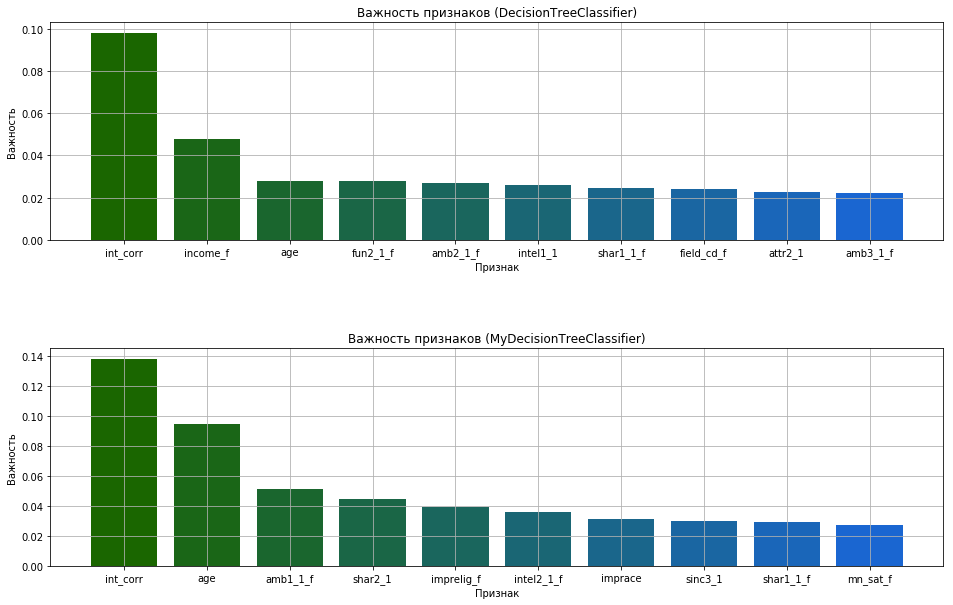

,clf_name,clf_feature_importances,myclf_name,myclf_feature_importances
0,int_corr,0.098335,int_corr,0.138411
1,income_f,0.047855,age,0.094870
2,age,0.027855,amb1_1_f,0.051226
3,fun2_1_f,0.027686,shar2_1,0.044696
4,amb2_1_f,0.026962,imprelig_f,0.039194
5,intel1_1,0.026019,intel2_1_f,0.035949
6,shar1_1_f,0.024738,imprace,0.031131
7,field_cd_f,0.023933,sinc3_1,0.029725
8,attr2_1,0.022870,shar1_1_f,0.029580
9,amb3_1_f,0.022107,mn_sat_f,0.027429


In [698]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
myclf = MyDecisionTreeClassifier()
myclf.fit(X_train, y_train)
features = df_pair.columns[1:]
features_answer = get_features(clf,myclf, features, n_plot = 10)
features_answer.head(10)

## Задание 4

In [356]:
# Определим пространство поиска
param_grid = {"max_depth": range(1,20), \
          "min_samples_split": range(2, 20), \
          "criterion": ["gini", "entropy"], \
             "n_estimators": range(5,100,5)
             }
# Будем делать 400 запусков поиска
model = RandomForestClassifier()
random_search = RandomizedSearchCV(model, param_grid, cv = 5, n_iter=400, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_params_

{'n_estimators': 65,
 'min_samples_split': 3,
 'max_depth': 15,
 'criterion': 'entropy'}